In [1]:
!python -m pip install torch torchvision torchaudio torchsummary einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.9 MB/s eta 0:00:00


In [2]:
"""
original code from rwightman:
https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
"""
from functools import partial
from collections import OrderedDict

import torch
torch.cuda.empty_cache()
import torch.nn as nn


def drop_path(x, drop_prob: float = 0., training: bool = False):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=0.):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class PatchEmbed(nn.Module):
    """
    2D Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_c=3, embed_dim=768, norm_layer=None):
        super().__init__()
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        # flatten: [B, C, H, W] -> [B, C, HW]
        # transpose: [B, C, HW] -> [B, HW, C]
        x = self.proj(x).flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x


class Attention(nn.Module):
    def __init__(self,
                 dim,   # 输入token的dim
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop_ratio=0.,
                 proj_drop_ratio=0.):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop_ratio)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop_ratio)

    def forward(self, x):
        # [batch_size, num_patches + 1, total_embed_dim]
        B, N, C = x.shape

        # qkv(): -> [batch_size, num_patches + 1, 3 * total_embed_dim]
        # reshape: -> [batch_size, num_patches + 1, 3, num_heads, embed_dim_per_head]
        # permute: -> [3, batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        # transpose: -> [batch_size, num_heads, embed_dim_per_head, num_patches + 1]
        # @: multiply -> [batch_size, num_heads, num_patches + 1, num_patches + 1]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # @: multiply -> [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        # transpose: -> [batch_size, num_patches + 1, num_heads, embed_dim_per_head]
        # reshape: -> [batch_size, num_patches + 1, total_embed_dim]
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Mlp(nn.Module):
    """
    MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Block(nn.Module):
    def __init__(self,
                 dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_ratio=0.,
                 attn_drop_ratio=0.,
                 drop_path_ratio=0.,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super(Block, self).__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                              attn_drop_ratio=attn_drop_ratio, proj_drop_ratio=drop_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop_ratio)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_c=3, num_classes=1000,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, qkv_bias=True,
                 qk_scale=None, representation_size=None, drop_ratio=0.,
                 attn_drop_ratio=0., drop_path_ratio=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_c (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            distilled (bool): model includes a distillation token and head as in DeiT models
            drop_ratio (float): dropout rate
            attn_drop_ratio (float): attention dropout rate
            drop_path_ratio (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
        """
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(img_size=img_size, patch_size=patch_size, in_c=in_c, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) 
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_ratio)

        dpr = [x.item() for x in torch.linspace(0, drop_path_ratio, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                  drop_ratio=drop_ratio, attn_drop_ratio=attn_drop_ratio, drop_path_ratio=dpr[i],
                  norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)
        ])
        self.norm = norm_layer(embed_dim)
 

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
 

        # Weight init
        nn.init.trunc_normal_(self.pos_embed, std=0.02) 

        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(_init_vit_weights)

    def forward_features(self, x):
        # [B, C, H, W] -> [B, num_patches, embed_dim]
        x = self.patch_embed(x)  # [B, 196, 768]
        # [1, 1, 768] -> [B, 1, 768]
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)  # [B, 197, 768] 

        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x


def _init_vit_weights(m):
    """
    ViT weight initialization
    :param m: module
    """
    if isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, std=.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.zeros_(m.bias)
        nn.init.ones_(m.weight)


def vit_base_patch16_224(num_classes: int = 1000):
    """
    ViT-Base model (ViT-B/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-1k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    链接: https://pan.baidu.com/s/1zqb08naP0RPqqfSXfkB2EA  密码: eu9f
    """
    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=768,
                              depth=12,
                              num_heads=12,
                              representation_size=None,
                              num_classes=num_classes)
    return model


def vit_base_patch16_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Base model (ViT-B/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_patch16_224_in21k-e5005f0a.pth
    """
    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=768,
                              depth=12,
                              num_heads=12,
                              representation_size=768 if has_logits else None,
                              num_classes=num_classes)
    return model


def vit_base_patch32_224(num_classes: int = 1000):
    """
    ViT-Base model (ViT-B/32) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-1k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    链接: https://pan.baidu.com/s/1hCv0U8pQomwAtHBYc4hmZg  密码: s5hl
    """
    model = VisionTransformer(img_size=224,
                              patch_size=32,
                              embed_dim=768,
                              depth=12,
                              num_heads=12,
                              representation_size=None,
                              num_classes=num_classes)
    return model


def vit_base_patch32_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Base model (ViT-B/32) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_patch32_224_in21k-8db57226.pth
    """
    model = VisionTransformer(img_size=224,
                              patch_size=32,
                              embed_dim=768,
                              depth=12,
                              num_heads=12,
                              representation_size=768 if has_logits else None,
                              num_classes=num_classes)
    return model


def vit_large_patch16_224(num_classes: int = 1000):
    """
    ViT-Large model (ViT-L/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-1k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    链接: https://pan.baidu.com/s/1cxBgZJJ6qUWPSBNcE4TdRQ  密码: qqt8
    """
    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=1024,
                              depth=24,
                              num_heads=16,
                              representation_size=None,
                              num_classes=num_classes)
    return model


def vit_large_patch16_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Large model (ViT-L/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_patch16_224_in21k-606da67d.pth
    """
    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=1024,
                              depth=24,
                              num_heads=16,
                              representation_size=1024 if has_logits else None,
                              num_classes=num_classes)
    return model


def vit_large_patch32_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Large model (ViT-L/32) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_patch32_224_in21k-9046d2e7.pth
    """
    model = VisionTransformer(img_size=224,
                              patch_size=32,
                              embed_dim=1024,
                              depth=24,
                              num_heads=16,
                              representation_size=1024 if has_logits else None,
                              num_classes=num_classes)
    return model


def vit_huge_patch14_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Huge model (ViT-H/14) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    NOTE: converted weights not currently available, too large for github release hosting.
    """
    model = VisionTransformer(img_size=224,
                              patch_size=14,
                              embed_dim=1280,
                              depth=32,
                              num_heads=16,
                              representation_size=1280 if has_logits else None,
                              num_classes=num_classes)
    return model


In [3]:
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))         

os.getcwd()
os.listdir('/kaggle/input')

data_path = '/kaggle/input/flower/flower'
assert os.path.exists(data_path), "{} path does not exist.".format(data_path) 

using cuda:0 device.


Using 3306 images for training, 364 images for validation.
100%|███████████████████████████████████████████████████████████████| 52/52 [01:01<00:00,  1.18s/it]
[Epoch 1/10] Train Loss: 1.6179, Train Accuracy: 0.2423, Validation Accuracy: 0.2500
100%|███████████████████████████████████████████████████████████████| 52/52 [00:47<00:00,  1.10it/s]
[Epoch 2/10] Train Loss: 1.3812, Train Accuracy: 0.3515, Validation Accuracy: 0.3654
100%|███████████████████████████████████████████████████████████████| 52/52 [00:47<00:00,  1.10it/s]
[Epoch 3/10] Train Loss: 1.3114, Train Accuracy: 0.4253, Validation Accuracy: 0.4423
100%|███████████████████████████████████████████████████████████████| 52/52 [00:47<00:00,  1.09it/s]
[Epoch 4/10] Train Loss: 1.1365, Train Accuracy: 0.5402, Validation Accuracy: 0.5467
100%|███████████████████████████████████████████████████████████████| 52/52 [00:47<00:00,  1.10it/s]
[Epoch 5/10] Train Loss: 1.0664, Train Accuracy: 0.5823, Validation Accuracy: 0.5769
100%|██████

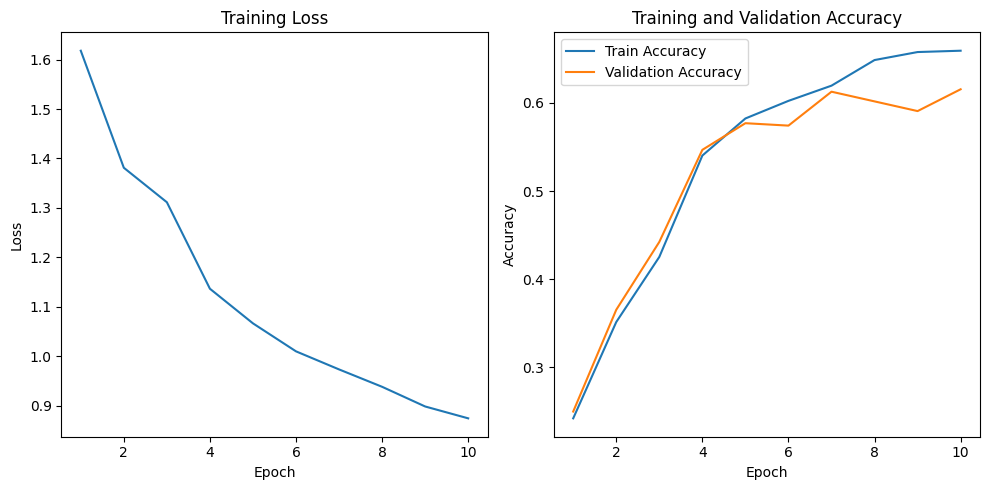

In [4]:
import os
import sys
import json
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

data_transform = {
    "train": transforms.Compose([transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),

    "val": transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

# Load datasets
train_dataset = datasets.ImageFolder(
    root=os.path.join(data_path, "train"), transform=data_transform["train"]
)
validate_dataset = datasets.ImageFolder(
    root=os.path.join(data_path, "val"), transform=data_transform["val"]
)
train_num = len(train_dataset)
val_num = len(validate_dataset)

# Define data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
validate_loader = torch.utils.data.DataLoader(
    validate_dataset, batch_size=4, shuffle=False
)

print(
    "Using {} images for training, {} images for validation.".format(
        train_num, val_num
    )
)

# Instantiate MLPMixer model and move to device
net = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=512,
                              depth=12,
                              num_heads=16,
                              representation_size=None,
                              num_classes=5).to(device)

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0002)

# Define training parameters
#save_path = "/content/drive/MyDrive/Research/Models"
epochs = 10
#save_path = os.path.join(os.getcwd(), "results/weights/mlp_mixer")
#os.makedirs(save_path, exist_ok=True)
save_path = os.path.abspath(os.path.join(os.getcwd(), '/kaggle/working/models'))
if not os.path.exists(save_path):
    os.makedirs(save_path)

best_acc = 0.0


train_losses = []
train_accuracies = []
val_accuracies = []
# Training loop
for epoch in range(epochs):
    # Train
    net.train()
    train_loss = 0.0
    correct_train = 0

    for images, labels in tqdm(train_loader, file=sys.stdout, ncols=100):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute training accuracy and loss
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = correct_train / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validate
    net.eval()
    correct_val = 0

    with torch.no_grad():
        for val_images, val_labels in validate_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = net(val_images)
            _, val_predicted = torch.max(val_outputs.data, 1)
            correct_val += (val_predicted == val_labels).sum().item()

    val_accuracy = correct_val / len(validate_loader.dataset)
    val_accuracies.append(val_accuracy)

    print(
        "[Epoch %d/%d] Train Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy: %.4f"
        % (epoch + 1, epochs, train_loss, train_accuracy, val_accuracy)
    )

    # Save the model if validation accuracy improves
    if val_accuracy > best_acc:
        best_acc = val_accuracy
        torch.save(net.state_dict(), os.path.join(save_path, "ViT.pth"))

print("Finished Training ViT")
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

class: daisy        prob: 0.218
class: dandelion    prob: 0.572
class: roses        prob: 0.0972
class: sunflowers   prob: 0.0106
class: tulips       prob: 0.102


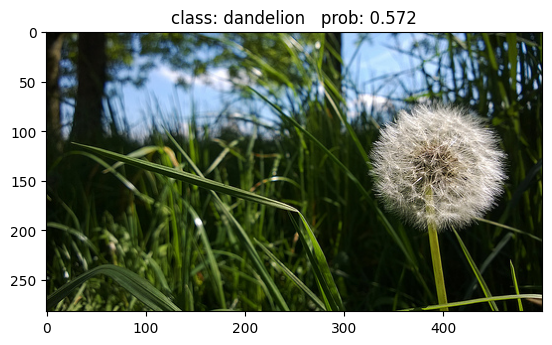

In [5]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

    # load image
#img_path = ("/content/drive/MyDrive/Research/Datasets/flower/val/roses/12406229175_82e2ac649c_n.jpg")
#img_path = ("/content/drive/MyDrive/Research/Datasets/flower/val/tulips/5012813078_99fb977616_n.jpg")
os.getcwd()

img_path = '/kaggle/input/flower/flower/val/dandelion/14185089716_2a48298d17.jpg'
# img_path = ("/kaggle/input/flower/flower/")

assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
img = Image.open(img_path)

plt.imshow(img)
    # [N, C, H, W]
img = data_transform(img)
    # expand batch dimension
img = torch.unsqueeze(img, dim=0)

    # read class_indict

json_path = "/kaggle/input/flower/flower/class_indices.json"
assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

json_file = open(json_path, "r")
class_indict = json.load(json_file)

    # create model
model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=512,
                              depth=12,
                              num_heads=16,
                              representation_size=None,
                              num_classes=5).to(device).to(device)

    # load model weights
weights_path = "/kaggle/working/models/ViT.pth"
#weights_path = "./results/weights/mlp_mixer/MLPMixer.pth"
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(
    weights_path
)
model.load_state_dict(torch.load(weights_path))

model.eval()
with torch.no_grad():
        # predict class
    output = torch.squeeze(model(img.to(device))).cpu()
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()

print_res = "class: {}   prob: {:.3}".format(
    class_indict[str(predict_cla)], predict[predict_cla].numpy()
)
plt.title(print_res)
for i in range(len(predict)):
    print(
        "class: {:10}   prob: {:.3}".format(
            class_indict[str(i)], predict[i].numpy()
        )
    )
plt.show()